# Урок 5. Случайный лес

# Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [77]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [78]:
# сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

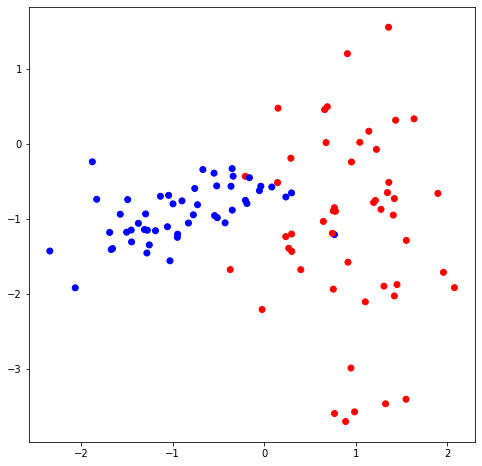

In [79]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [80]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = [] # новая бутстреп выборка
    
    for i in range(N): # цикл по кол-ву деревьев
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1) # выбираем индекс нового объекта бутстреп выборки
            b_data[j] = data[sample_index] 
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

В задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту

**Комментарий про subsample:** всё верно, подмножество признаков формируется при каждом разбиении
    
Детали: Разбиение объектов в вершине случайного леса ищется среди случайного подмножества признаков, а обучение каждого дерева в композиции происходит на выборке, полученной с помощью операции бутстрапа. http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf (3.4 Метод случайных подпространств)

In [81]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes) # перемешаем индексы
    subsample = sample_indexes[0:len_subsample].copy() # возьмем первые len_subsample
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    #print(f'subsample = {subsample}')
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [82]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [83]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

В качестве функции оценки качества разбиения используется критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [84]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
# !!! ИЗМЕНЕНИЯ !!! 
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample: # выбираем из подпространства признаков, для каждого нового разбиения будет новое подпространство 
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [85]:
def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
        
    return forest

In [86]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)  
    
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    #print(f'predictions_per_object = {predictions_per_object}')  
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    #print(f'voted_predictions = {voted_predictions}')    
    return voted_predictions

In [87]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [88]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [89]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [90]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [91]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [92]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 92.857


In [93]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 86.667


Построим лес из трех деревьев

In [94]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [95]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [96]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [97]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 92.857


In [98]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 86.667


Построим лес из десяти деревьев

In [99]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [100]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [101]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [102]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 95.714


In [103]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 86.667


Построим лес из пятидесяти деревьев

In [104]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [105]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [106]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [107]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 95.714


In [108]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 90.000


Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем. При этом по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес не переобучается. Это одна из основных особенностей случайного леса - он не переобучается при увеличении числа базовых алгоритмов, а ошибка выходит на асимптоту.

In [109]:
def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
xx, yy = get_meshgrid(classification_data)

Text(0.5, 1.0, '50 Деревьев')

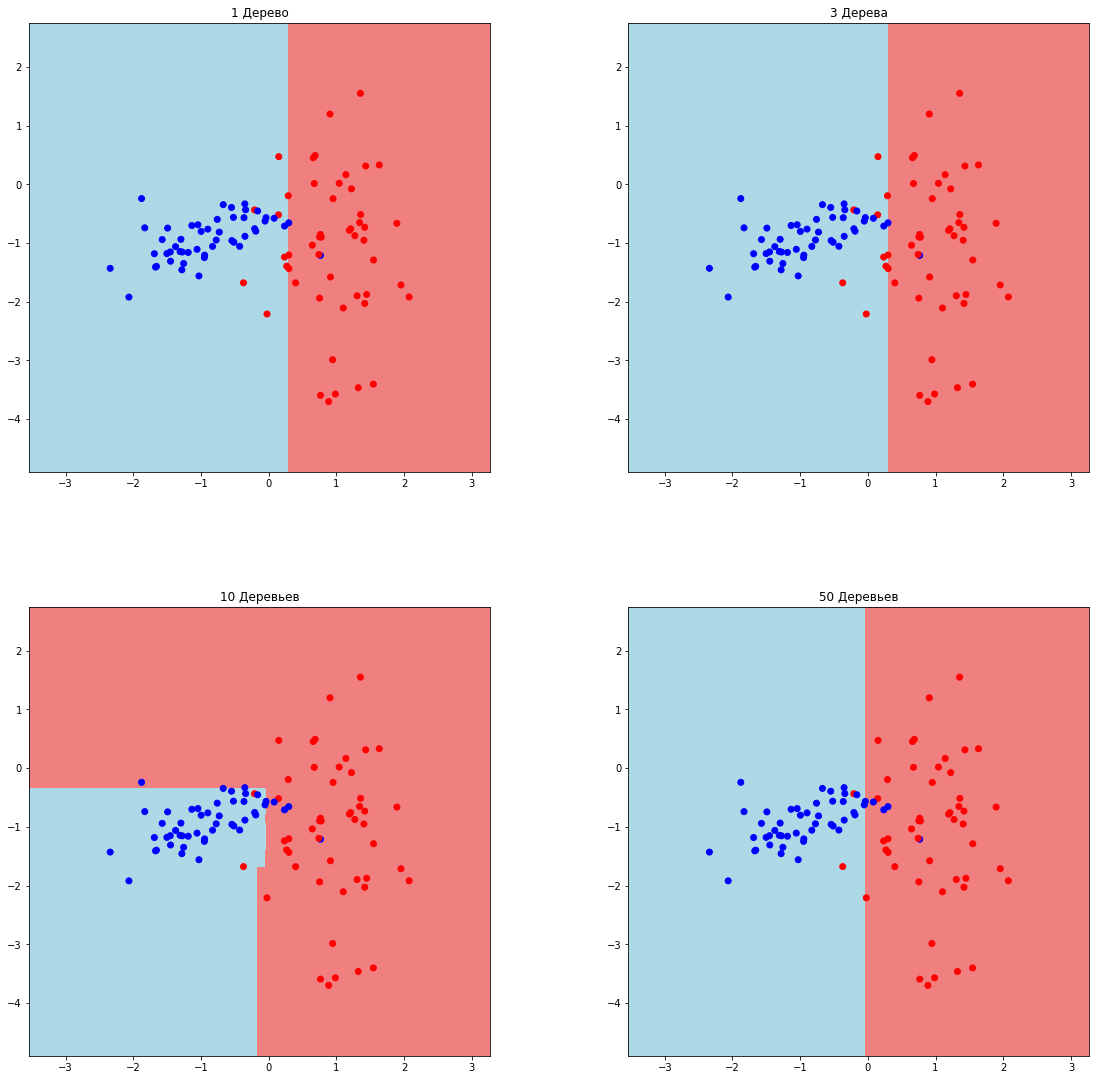

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.set_size_inches(19, 19, forward=True)
ax1, ax2, ax3, ax4 = ax.flatten()

# график  выборки, tree_1
mesh_predictions = np.array(tree_vote(my_forest_1,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax1.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax1.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax1.set_title('1 Дерево')

# график  выборки, tree_3
mesh_predictions = np.array(tree_vote(my_forest_3,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax2.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax2.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax2.set_title('3 Дерева')

# график  выборки, tree_10
mesh_predictions = np.array(tree_vote(my_forest_10,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax3.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax3.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax3.set_title('10 Деревьев')

# график  выборки, tree_50
mesh_predictions = np.array(tree_vote(my_forest_50,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax4.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax4.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax4.set_title('50 Деревьев')

# Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

3*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

## Литература

1. [Смещение и разброс](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)
2. [Бэггинг с точки зрения статистики](https://habr.com/ru/company/ods/blog/324402/#begging)
3. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
4. [Случайный лес (Random Forest)](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/)
5. [Реализация и разбор алгоритма «случайный лес» на Python](https://tproger.ru/translations/python-random-forest-implementation/)
6. [Прикладные задачи анализа данных. Случайные леса](http://www.machinelearning.ru/wiki/images/c/cc/PZAD2016_09_rf.pdf)
7. Андреас Мюллер, Сара Гвидо, Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными (2016)

## Summary

__Преимущества случайного леса__

* Один из сильнейших “классических" алгоритмов машинного обучения
* Не требователен к обучающей выборке (не требуется нормализация, очистка от шума, ...) 
* Легко параллелится, так как базовые модели обучаются независимо друг от друга
* Не подвержен переобучению 
* Дает оценку важности признаков (feature importance)
* Не требует дополнительной валидационной выборки (за счет OOB-score)

__Недостатки случайного леса__

* Как и у решающих деревьев, нет экстраполяции данных
* Чувствителен к разреженным признакам

## Q&A

__1. "Жюри присяжных"__

* Пусть имеется жюри из N присяжных, принимающих решение независимо друг от друга
* Пусть вероятность “правильного” приговора у каждого присяжного = p
* Чему равна вероятность “правильного” приговора жюри, если голосуют “большинством”?

<img src="data/L5_Q1.png" style="width: 800px;">

__2. Как еще можно усреднить предсказания в случайном лесу, помимо простого голосования?__

<img src="data/L5_Q2.png" style="width: 600px;">

__3. Задача на выборочную оценку статистики__

* Пусть θ - некоторый параметр генеральной совокупности, для которого нужно оценить стандартную ошибку, то есть ищем Std(θ)
* В распоряжении у нас есть только случайная выборка X размера N: (x1, x2, ..., xN)
* По выборке X можно сделать оценку для θ: <θ>N

Как оценить Std(θ)?

<img src="data/L5_Q3.png" style="width: 330px;">
<img src="data/L5_Bootstrap.png" style="width: 400px;">

__4. Почему бутстреп использует в среднем только ~63% данных, а оставшиеся ~37% не используются (OOB)?__

<img src="data/L5_Q4.png" style="width: 700px;">

__5. Почему решающее дерево - хороший кандидат на роль базовой модели для бэггинга / случайного леса?__

<img src="data/L5_Q5.png" style="width: 350px;">

__6. Как оценить важность признаков с помощью деревьев?__

<img src="data/L5_Q6_1.png" style="width: 700px;">

<img src="data/L5_Q6_2.png" style="width: 700px;">

In [ ]:
Permutation Importance

__7. Зачем в случайных лесах брать подпространство признаков?__

<img src="data/L5_Q7.png" style="width: 350px;">

__8. Как наличие разреженных признаков отразится на работе случайного леса?__

<img src="data/L5_Q8.png" style="width: 300px;">